In [ ]:
# TẢI DỮ LIỆU ĐƯỢC LƯU TỪ LINK DRIVE (LINK CHỨA DATA)
!pip install -q gdown
import gdown
# File 1
id1 = '1oxWr6TQApjbUA7cL8riCIIIWa4AaN0S2'
url1 = f'https://drive.google.com/uc?id={id1}'
output1 = 'offerings.csv'
gdown.download(url1, output1, quiet=False)

# File 2
id2 = '1NHKihgfjZ_Yy-XdQeRtfgIZ-PBHUAUWW'
url2 = f'https://drive.google.com/uc?id={id2}'
output2 = 'reviews.csv'
gdown.download(url2, output2, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oxWr6TQApjbUA7cL8riCIIIWa4AaN0S2
To: /content/offerings.csv
100%|██████████| 1.22M/1.22M [00:00<00:00, 64.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1NHKihgfjZ_Yy-XdQeRtfgIZ-PBHUAUWW
From (redirected): https://drive.google.com/uc?id=1NHKihgfjZ_Yy-XdQeRtfgIZ-PBHUAUWW&confirm=t&uuid=9aa84669-d734-4b6c-9e30-82a66cd971bd
To: /content/reviews.csv
100%|██████████| 133M/133M [00:01<00:00, 130MB/s]


'reviews.csv'

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import scipy.sparse as sp
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Tải tài nguyên NLTK
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

TIỀN XỬ LÍ DỮ LIỆU

In [ ]:
# Đọc cả 2 file
hotels = pd.read_csv(output1, on_bad_lines='skip')
reviews = pd.read_csv(output2, on_bad_lines='skip')
print(hotels.info())
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hotel_class  3141 non-null   float64
 1   region_id    4333 non-null   int64  
 2   url          4333 non-null   object 
 3   phone        0 non-null      float64
 4   details      0 non-null      float64
 5   address      4333 non-null   object 
 6   type         4333 non-null   object 
 7   id           4333 non-null   int64  
 8   name         4333 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 304.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112900 entries, 0 to 112899
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ratings            112900 non-null  object 
 1   title              112900 non-null  object 
 2   text               112900 non-null  object 
 3   au

DATA SẼ ĐƯỢC BIỂU DIỄN BẰNG BIẾN df

In [ ]:
# Đổi tên cột và ghép dữ liệu
hotels = hotels.rename(columns={'id': 'offering_id'})
df = pd.merge(reviews, hotels, on='offering_id', how='inner')

# Loại bỏ cột không cần thiết
df = df.drop(['author', 'url', 'phone', 'details', 'id', 'via_mobile'], axis=1)

# Kiểm tra trùng lặp
print("Duplicate rows in hotels:", hotels.duplicated().sum())

# Thêm giá tiền mỗi đêm (giả lập dựa trên hotel_class)
def generate_price(hotel_class):
    if np.isnan(hotel_class):
        return np.nan
    if hotel_class <= 1:
        return np.random.uniform(50, 100)
    elif hotel_class <= 2:
        return np.random.uniform(100, 150)
    elif hotel_class <= 3:
        return np.random.uniform(150, 250)
    elif hotel_class <= 4:
        return np.random.uniform(250, 400)
    else:
        return np.random.uniform(400, 1000)

df['price_per_night'] = df['hotel_class'].apply(generate_price)

# Chuyển đổi cột date và date_stayed sang định dạng datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date_stayed'] = pd.to_datetime(df['date_stayed'], errors='coerce')

Duplicate rows in hotels: 0


In [ ]:
import json
# Hàm xử lý chuỗi JSON
def clean_json(x):
    if isinstance(x, str):
        return json.loads(x.replace("'", '"'))
    elif isinstance(x, dict):
        return x
    else:
        raise ValueError(f"Unexpected type for ratings: {type(x)}")

# Xử lý cột ratings
df['ratings'] = df['ratings'].apply(clean_json)
normalized_cols = pd.json_normalize(df['ratings'])

# Xóa các cột trùng lặp trong df
duplicate_columns = [col for col in normalized_cols.columns if col in df.columns]
df = df.drop(columns=duplicate_columns, errors='ignore')

# Ghép normalized_cols vào df
df = df.join(normalized_cols)

# Xóa cột ratings
df = df.drop(['ratings'], axis=1)

# Xử lý giá trị thiếu cho các cột hiện có
df['date_stayed'] = df['date_stayed'].fillna('Unknown')
df['hotel_class'] = df['hotel_class'].fillna(df['hotel_class'].median())
df['price_per_night'] = df['price_per_night'].fillna(df['price_per_night'].median())
df['text'] = df['text'].fillna('No content')

# Xử lý giá trị thiếu cho các cột đánh giá
rating_columns = [
    'service', 'cleanliness', 'value', 'rooms', 'check_in_front_desk',
    'location', 'sleep_quality', 'business_service_(e_g_internet_access)'
]

# Điền giá trị thiếu bằng trung vị theo hotel_class
for col in rating_columns:
    df[col] = df.groupby('hotel_class')[col].transform(lambda x: x.fillna(x.median()))

# Điền giá trị thiếu còn lại bằng trung vị tổng thể
for col in rating_columns:
    df[col] = df[col].fillna(df[col].median())

# Kiểm tra lại giá trị thiếu
print("Giá trị thiếu sau khi xử lý:")
print(df.isnull().sum())

# Kiểm tra kết quả
print(df.head())

Giá trị thiếu sau khi xử lý:
title                                     0
text                                      0
date_stayed                               0
offering_id                               0
num_helpful_votes                         0
date                                      0
sentiment                                 0
hotel_class                               0
region_id                                 0
address                                   0
type                                      0
name                                      0
price_per_night                           0
overall                                   0
service                                   0
cleanliness                               0
value                                     0
rooms                                     0
check_in_front_desk                       0
location                                  0
sleep_quality                             0
business_service_(e_g_internet_access)    0
dty

In [ ]:
# Phân tích cảm xúc từ văn bản bằng VADER
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = sid.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['text'].apply(get_sentiment)

In [ ]:
# Chuẩn hóa đặc trưng số
scaler = StandardScaler()
numeric_cols = ['num_helpful_votes', 'hotel_class', 'price_per_night']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
# Xử lý giá trị ngoại lệ bằng IQR
for col in ['num_helpful_votes', 'price_per_night']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112899 entries, 0 to 112898
Data columns (total 22 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   title                                   112899 non-null  object        
 1   text                                    112899 non-null  object        
 2   date_stayed                             112899 non-null  object        
 3   offering_id                             112899 non-null  float64       
 4   num_helpful_votes                       112899 non-null  float64       
 5   date                                    112899 non-null  datetime64[ns]
 6   sentiment                               112899 non-null  object        
 7   hotel_class                             112899 non-null  float64       
 8   region_id                               112899 non-null  int64         
 9   address                              

In [ ]:
# Lưu dữ liệu đã xử lí nếu cần (bỏ '#' để lưu)
# df.to_csv("processed_data.csv", index=False)

# print("Đã lưu df vào file processed_data.csv")

Đã lưu df vào file processed_data.csv


PHÂN TÍCH THỐNG KÊ SƠ BỘ

In [ ]:
# Phân tích thống kê
print("Thống kê mô tả cho các đặc trưng số:")
print(df[numeric_cols].describe())

# Thống kê tổng thể
print("\nPhân phối nhãn sentiment:")
print(df['sentiment'].value_counts(normalize=True))

# Thống kê TF-IDF (tính sau khi xử lý văn bản)
tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(df['text'])
print("\nKích thước ma trận TF-IDF:", tfidf_matrix.shape)
print("Số lượng giá trị khác 0 trong TF-IDF:", tfidf_matrix.nnz)
print("Tỷ lệ thưa thớt:", tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))

Thống kê mô tả cho các đặc trưng số:
       num_helpful_votes   hotel_class  price_per_night
count      112899.000000  1.128990e+05    112899.000000
mean           -0.178952 -6.444661e-17        -0.098538
std             0.343000  1.000004e+00         0.708920
min            -0.462257 -3.338920e+00        -1.631943
25%            -0.462257 -6.802791e-01        -0.609241
50%            -0.462257 -1.561877e-02        -0.149483
75%            -0.104027  6.490415e-01         0.269611
max             0.433318  1.978362e+00         1.587888

Phân phối nhãn sentiment:
sentiment
Positive    0.732805
Negative    0.187734
Neutral     0.079460
Name: proportion, dtype: float64

Kích thước ma trận TF-IDF: (112899, 1000)
Số lượng giá trị khác 0 trong TF-IDF: 4482701
Tỷ lệ thưa thớt: 0.03970540925960372


In [ ]:
# Lấy tên các đặc trưng (cột)
feature_names = tfidf.get_feature_names_out()

# Chuyển sang DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Lưu vào file CSV NẾU CẦN THÌ bỏ dấu chú thích '#'
# tfidf_df.to_csv("tfidf_vectors.csv", index=False)

# print("Đã lưu TF-IDF vào file tfidf_vectors.csv")

Đã lưu TF-IDF vào file tfidf_vectors.csv


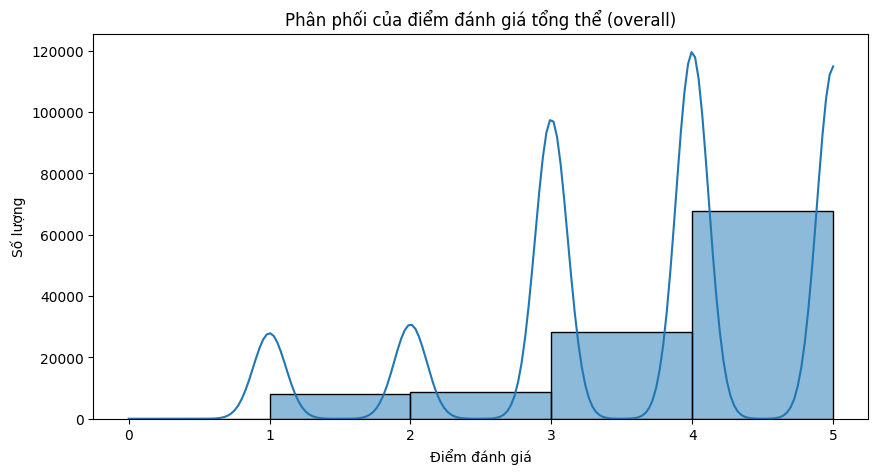

In [ ]:
# 1. Histogram cho phân phối của điểm đánh giá tổng thể
plt.figure(figsize=(10, 5))
sns.histplot(df['overall'], bins=5, kde=True)
plt.title('Phân phối của điểm đánh giá tổng thể (overall)')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.show()

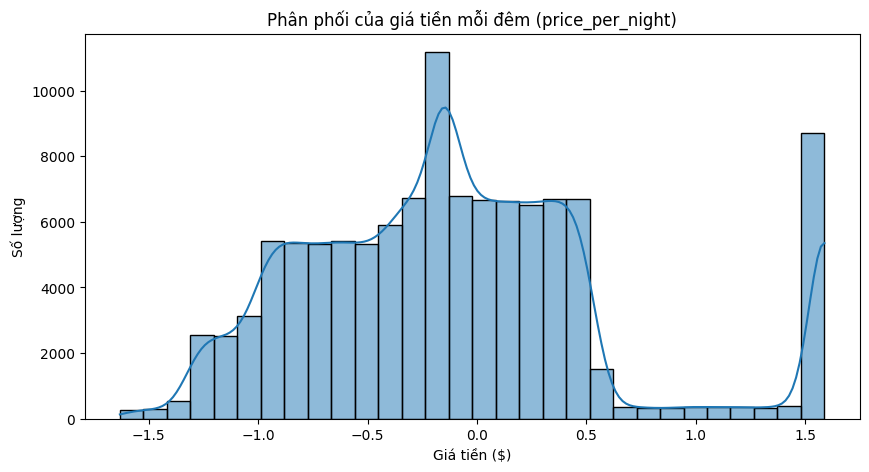

In [ ]:
# 1. Histogram cho phân phối của giá tiền mỗi đêm
plt.figure(figsize=(10, 5))
sns.histplot(df['price_per_night'], bins=30, kde=True)
plt.title('Phân phối của giá tiền mỗi đêm (price_per_night)')
plt.xlabel('Giá tiền ($)')
plt.ylabel('Số lượng')
plt.show()

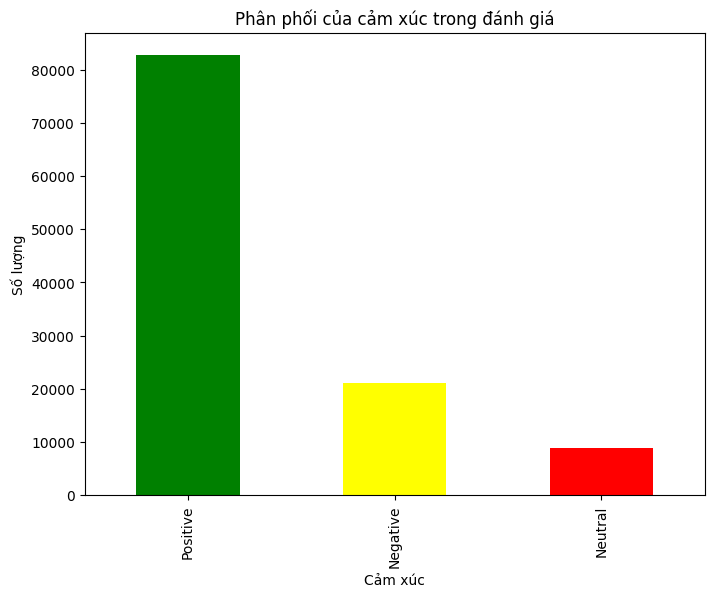

In [ ]:
# 3. Biểu đồ cột cho phân phối cảm xúc
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Phân phối của cảm xúc trong đánh giá')
plt.xlabel('Cảm xúc')
plt.ylabel('Số lượng')
plt.show()

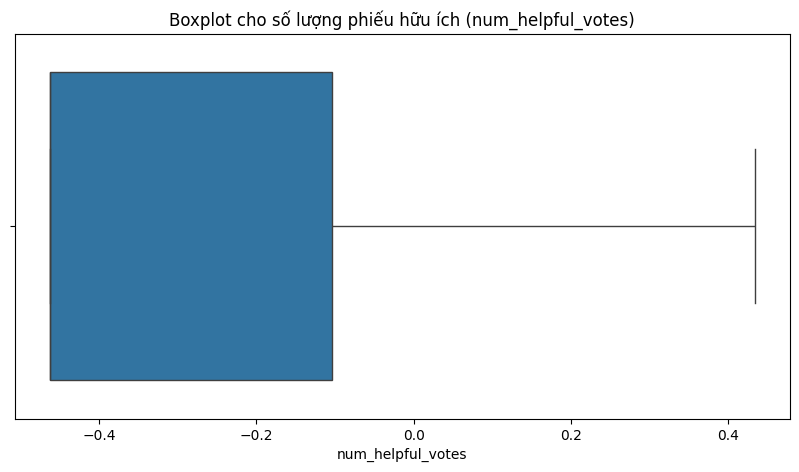

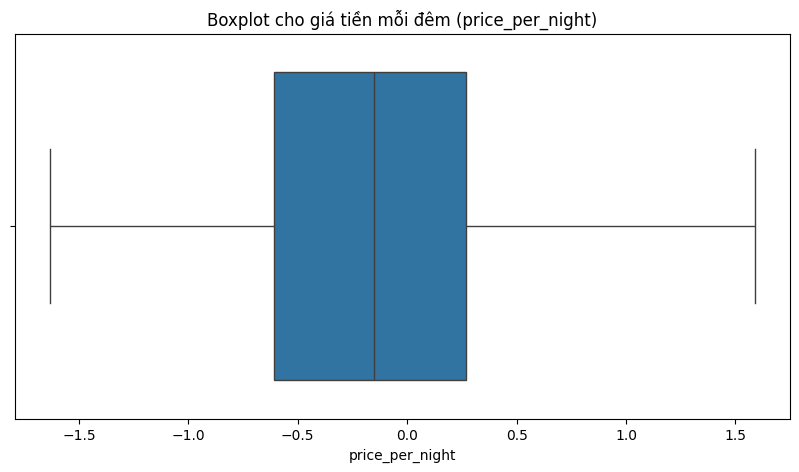

In [ ]:
# 4. Boxplot cho các giá trị ngoại lệ
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['num_helpful_votes'])
plt.title('Boxplot cho số lượng phiếu hữu ích (num_helpful_votes)')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['price_per_night'])
plt.title('Boxplot cho giá tiền mỗi đêm (price_per_night)')
plt.show()

SỬ DỤNG CÁC MÔ HÌNH PHÂN LOẠI VÀ GIẢM CHIỀU

- Giảm chiều

In [ ]:
X = df[numeric_cols + ['text']]
y = df['sentiment']

# Chia dữ liệu thành train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Xử lý TF-IDF
tfidf_train = tfidf.fit_transform(X_train['text'])
tfidf_test = tfidf.transform(X_test['text'])

# Kết hợp đặc trưng số và TF-IDF
X_train_combined = np.hstack([X_train[numeric_cols].to_numpy(), tfidf_train.toarray()])
X_test_combined = np.hstack([X_test[numeric_cols].to_numpy(), tfidf_test.toarray()])

In [ ]:
# Giảm chiều với PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_combined)
X_test_pca = pca.transform(X_test_combined)
print("\nSố chiều sau PCA:", X_train_pca.shape[1])
print("Phương sai giải thích (PCA):", pca.explained_variance_ratio_)
print("Tổng phương sai bảo tồn (PCA):", sum(pca.explained_variance_ratio_))


Số chiều sau PCA: 655
Phương sai giải thích (PCA): [5.50731049e-01 4.76093799e-02 3.89636087e-02 1.16894598e-02
 8.54875393e-03 6.65770893e-03 5.38021928e-03 3.71038725e-03
 2.94295831e-03 2.74539571e-03 2.49681832e-03 2.11354506e-03
 2.02046950e-03 1.89416439e-03 1.82243444e-03 1.76354213e-03
 1.67135330e-03 1.66575862e-03 1.59342784e-03 1.57394498e-03
 1.47103345e-03 1.43345153e-03 1.40264684e-03 1.33801865e-03
 1.26530894e-03 1.23306663e-03 1.20513264e-03 1.19376552e-03
 1.16551002e-03 1.15825072e-03 1.15017205e-03 1.11387806e-03
 1.08015198e-03 1.07100623e-03 1.04118433e-03 1.03190041e-03
 1.01150605e-03 1.00316337e-03 9.96479020e-04 9.72854950e-04
 9.62351806e-04 9.52650459e-04 9.46138037e-04 9.34934019e-04
 9.20993513e-04 9.14179494e-04 9.12967837e-04 9.00166688e-04
 8.96651159e-04 8.83519361e-04 8.67005292e-04 8.59447286e-04
 8.50103903e-04 8.49327461e-04 8.38216429e-04 8.27265452e-04
 8.23319616e-04 8.15645347e-04 7.95443650e-04 7.91977416e-04
 7.90420175e-04 7.77222925e-04 7.

In [ ]:
# Giảm chiều với TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(sp.hstack([sp.csr_matrix(X_train[numeric_cols]), tfidf_train]))
X_test_svd = svd.transform(sp.hstack([sp.csr_matrix(X_test[numeric_cols]), tfidf_test]))
print("\nSố chiều sau TruncatedSVD:", X_train_svd.shape[1])
print("Phương sai giải thích (SVD):", svd.explained_variance_ratio_)
print("Tổng phương sai bảo tồn (SVD):", sum(svd.explained_variance_ratio_))


Số chiều sau TruncatedSVD: 100
Phương sai giải thích (SVD): [0.55064693 0.03890287 0.03938931 0.01394178 0.00906046 0.00740008
 0.00665341 0.00537909 0.00371035 0.00281341 0.00249683 0.00218299
 0.00210529 0.00201637 0.00188394 0.0018074  0.00176211 0.00166999
 0.00166422 0.00158397 0.00149653 0.00144127 0.00140539 0.00139174
 0.00133375 0.00126325 0.00123296 0.0011937  0.00118078 0.00116484
 0.0011563  0.00111855 0.00108348 0.00107991 0.00105004 0.00103165
 0.0010153  0.00100609 0.00099971 0.0009802  0.00096203 0.00096078
 0.0009478  0.00093686 0.00091893 0.00091399 0.00091197 0.00089782
 0.0008944  0.00088431 0.00086731 0.00085762 0.00084895 0.00084536
 0.00083654 0.00082746 0.00081977 0.00081008 0.00079155 0.00078753
 0.00078271 0.0007747  0.00076753 0.00076229 0.000755   0.00074709
 0.00074191 0.00073902 0.00073205 0.00072464 0.00072119 0.00071426
 0.00071288 0.0007066  0.00069933 0.00069523 0.00069145 0.00068076
 0.00067799 0.00067344 0.00066857 0.0006601  0.00065438 0.00064987
 

In [ ]:
# Chuẩn hóa dữ liệu giảm chiều
scaler_pca = StandardScaler()
X_train_pca_scaled = scaler_pca.fit_transform(X_train_pca)
X_test_pca_scaled = scaler_pca.transform(X_test_pca)

scaler_svd = StandardScaler()
X_train_svd_scaled = scaler_svd.fit_transform(X_train_svd)
X_test_svd_scaled = scaler_svd.transform(X_test_svd)

# Thống kê mô tả cho dữ liệu sau giảm chiều
print("\nThống kê mô tả cho dữ liệu sau PCA:")
print(pd.DataFrame(X_train_pca_scaled).describe())

print("\nThống kê mô tả cho dữ liệu sau TruncatedSVD:")
print(pd.DataFrame(X_train_svd_scaled).describe())


Thống kê mô tả cho dữ liệu sau PCA:
                0             1             2             3             4    \
count  9.031900e+04  9.031900e+04  9.031900e+04  9.031900e+04  9.031900e+04   
mean  -1.433767e-17  3.245152e-18 -2.112299e-17  1.899889e-17  1.235124e-17   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -3.065938e+00 -1.268950e+00 -2.220320e+00 -1.931415e+00 -2.029951e+00   
25%   -7.536787e-01 -8.288794e-01 -7.142246e-01 -6.668890e-01 -2.904219e-01   
50%    2.030268e-01 -5.276235e-01 -5.949626e-02 -3.018084e-01 -1.459847e-01   
75%    5.795204e-01  6.181820e-01  6.029311e-01  2.748631e-01  2.355799e-02   
max    2.185503e+00  2.211913e+00  2.823432e+00  4.298871e+00  5.999984e+00   

                5             6             7             8             9    \
count  9.031900e+04  9.031900e+04  9.031900e+04  9.031900e+04  9.031900e+04   
mean   1.801551e-17 -3.835180e-18 -2.617756e-17  1.239058e-17  2.163435e-19   
std    1.00000

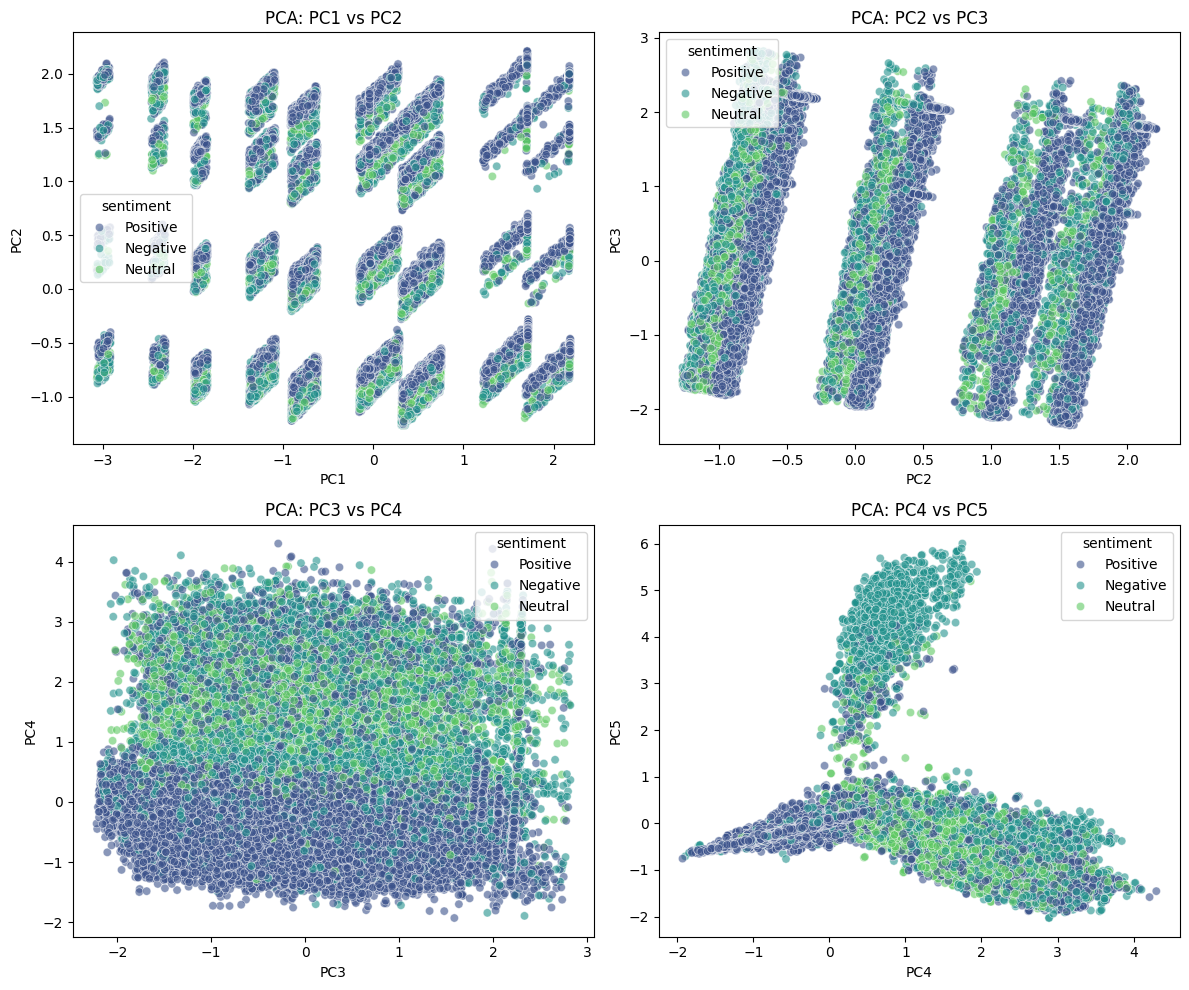

In [ ]:
# Trực quan hóa 4 cặp thành phần chính (PCA)
plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=X_train_pca_scaled[:, i], y=X_train_pca_scaled[:, i+1], hue=y_train, palette='viridis', alpha=0.6)
    plt.title(f'PCA: PC{i+1} vs PC{i+2}')
    plt.xlabel(f'PC{i+1}')
    plt.ylabel(f'PC{i+2}')
plt.tight_layout()
plt.show()

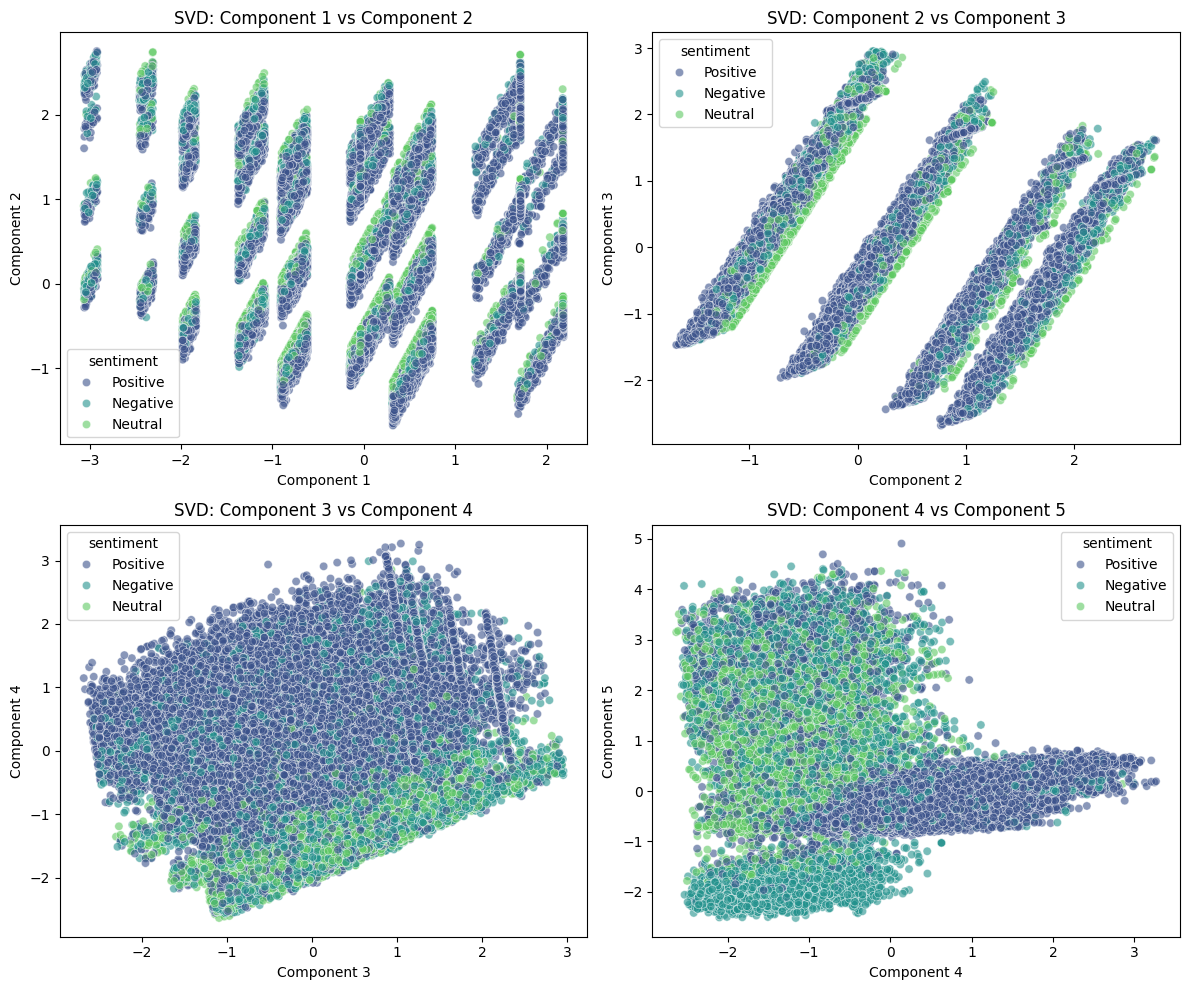

In [ ]:
# Trực quan hóa 4 cặp thành phần chính (SVD)
plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=X_train_svd_scaled[:, i], y=X_train_svd_scaled[:, i+1], hue=y_train, palette='viridis', alpha=0.6)
    plt.title(f'SVD: Component {i+1} vs Component {i+2}')
    plt.xlabel(f'Component {i+1}')
    plt.ylabel(f'Component {i+2}')
plt.tight_layout()
plt.show()

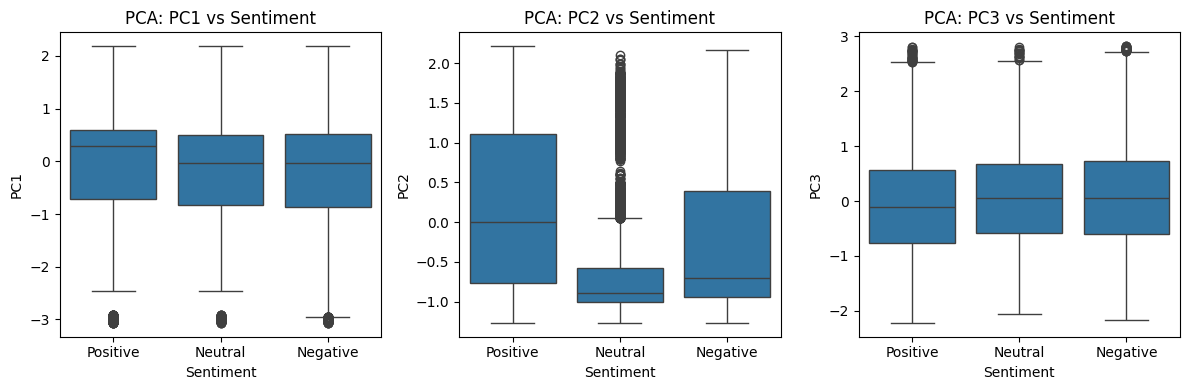

In [ ]:
# Tạo DataFrame từ X_train_pca_scaled và y_train để trực quan hóa
pca_df = pd.DataFrame(X_train_pca_scaled, columns=[f'PC{i+1}' for i in range(X_train_pca_scaled.shape[1])])
pca_df['sentiment'] = y_train.reset_index(drop=True)

# Trực quan hóa mối quan hệ giữa thành phần chính và sentiment (PCA)
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='sentiment', y=f'PC{i+1}', data=pca_df, order=['Positive', 'Neutral', 'Negative'])
    plt.title(f'PCA: PC{i+1} vs Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel(f'PC{i+1}')
plt.tight_layout()
plt.show()

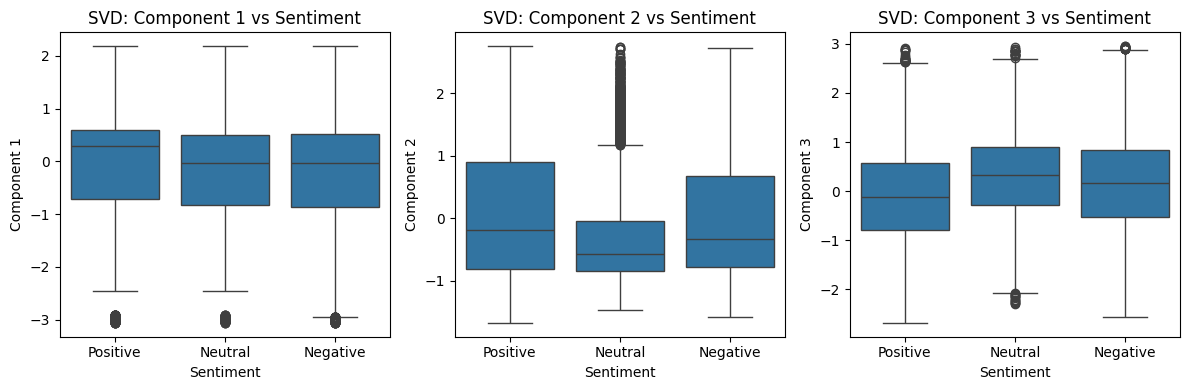

In [ ]:
# Tạo DataFrame từ X_train_svd_scaled và y_train để trực quan hóa
svd_df = pd.DataFrame(X_train_svd_scaled, columns=[f'Component {i+1}' for i in range(X_train_svd_scaled.shape[1])])
svd_df['sentiment'] = y_train.reset_index(drop=True)

# Trực quan hóa mối quan hệ giữa thành phần chính và sentiment (SVD)
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='sentiment', y=f'Component {i+1}', data=svd_df, order=['Positive', 'Neutral', 'Negative'])
    plt.title(f'SVD: Component {i+1} vs Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel(f'Component {i+1}')
plt.tight_layout()
plt.show()

In [ ]:
# So sánh PCA và TruncatedSVD
print("\nSo sánh PCA và TruncatedSVD:")
print(f"PCA: {X_train_pca.shape[1]} chiều, bảo tồn {sum(pca.explained_variance_ratio_):.2%} phương sai")
print(f"SVD: {X_train_svd.shape[1]} chiều, bảo tồn {sum(svd.explained_variance_ratio_):.2%} phương sai")

# Đánh giá thời gian xử lý
start_time = time.time()
pca.fit(X_train_combined)
pca_time = time.time() - start_time

start_time = time.time()
svd.fit(sp.hstack([sp.csr_matrix(X_train[numeric_cols]), tfidf_train]))
svd_time = time.time() - start_time

print(f"Thời gian PCA: {pca_time:.2f} giây")
print(f"Thời gian SVD: {svd_time:.2f} giây")


So sánh PCA và TruncatedSVD:
PCA: 655 chiều, bảo tồn 95.00% phương sai
SVD: 100 chiều, bảo tồn 76.51% phương sai
Thời gian PCA: 33.21 giây
Thời gian SVD: 6.92 giây
